# Assigment 4 - IML and xAI with shap
Submission DDL: 01.12.2024 23:59.

* Submit your work to the submission box on MyCourses. You should submit only the **.ipynb file** with your code.
* To download the file from Google Colab use *File* > *Download* > *Download .ipynb*.
* Submit the file with the name: A4_NAME_SURNAME_STUDENT NUMBER.ipynb

**NB! Before editing the file, save a local copy to your Google Drive, otherwise your progress will be lost**

In this assignment you will combine the knowledge acquired earlier in the course with the content of Module 4. The task contains 2 parts: explanation of a model with tabular data and explanation of a model with image/text data. You are encouraged to use the code from the previous tutorials as well as from your previous assignments. There is no specific task-related code provided. Main modules are imported for your convenience. You can load any other modules you find useful.
Please, keep your code rather clean and understandable. Descriptions of tasks are provided after imports.

In [79]:
# install shap transformers datasets
!pip install shap transformers datasets

In [146]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import urllib
import io

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns


import shap

student_number = 863522 # INPUT YOUR STUDENT NUMBER HERE, omit the letters
assert type(student_number) is int, "Exclude letters, leave only numbers"

np.random.seed(student_number)
torch.manual_seed(student_number)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [81]:
import sys
import os
import getpass

# define the main directory
# check if running on Google Colab
if 'google.colab' in str(get_ipython()):

    print('Running on Colab')

    # import the Google Colab GDrive connector
    from google.colab import drive

    # mount GDrive inside the Colab notebook
    drive.mount('/content/drive')

    # name Colab Notebooks directory
    main_directory = '/content/drive/MyDrive/Colab Notebooks/dsfb2/a4'

else:
    # check if running on MacOS
    if sys.platform == 'darwin':
        print('Running on MacOS')

        # get the username
        user_name = getpass.getuser()

        # name main directory
        main_directory = f"/Users/{user_name}/dsfb2/a4"

    # check if running on Windows
    elif sys.platform == 'win32':
        print('Running on Windows')

        # get the username
        user_name = getpass.getuser()

        # name main directory
        main_directory = f"C:/Users/{user_name}/dsfb2/a4"

# create the main directory
if not os.path.exists(main_directory): os.makedirs(main_directory)


Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task A - Tabular data - 12 points
Your task is to build a model on some tabular data and explain predictions and observations using SHAP. The task consists of the following parts:
- **A1** - find the suitable dataset (contains at least 3 features), import it and describe. Provide vizualizations. Shortly describe the problem you're solving (e.g. predicting price, customer churn, etc) **(1 points)** \
 *Recommendation:* find a simple and clean dataset with at least 3 features, preferably with the continuous target variable - then you can apply the same explanations as in the tutorial. If you do some data processing, shortly describe it.
- **A2** - build a non-interpretable predictive model (regression/classification, depending on your data, you need to select only one). Assess the performance of the model using the suitable metrics of your choice. Write a short report (several sentences) on the model performance **(4 points)** \
 *Recommendation:* use XGBoost or RandomForestClassifier depending on your data. In terms of performance, try to achieve $R^2 \geq 0.5$ for regression and better than random guessing accuracy for classification. For performance assessment use at least $R^2$ and MSE or accuracy(recall) and confusion matrix. It is better to build a solid model on simple data rather rather than try to build some fancy model on fancy data.
- **A3** - interpret the model results using SHAP. Write full interpretation for each feature for one of the observations. Show the waterfall plot for this observation. Show the bar plot for the mean absolute SHAP values as well. Shortly explain the meaning of that plot. **(7 points)** \
 Recommendation: Correct formulation of interpretation is extremely important, please check the lecture and the tutorial.

*General recommendation:* You can follow the tutorial with the dataset of your choice. Keep your explanations rather simple. The main aim is for you to show that you understand how to build and to explain the model. Your code and short reports should show your understanding.

In [82]:
# starting code cell for part A
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dsfb2/a4/housing_price_dataset.csv')
print(df.describe)

<bound method NDFrame.describe of        SquareFeet  Bedrooms  Bathrooms Neighborhood  YearBuilt          Price
0            2126         4          1        Rural       1969  215355.283618
1            2459         3          2        Rural       1980  195014.221626
2            1860         2          1       Suburb       1970  306891.012076
3            2294         2          1        Urban       1996  206786.787153
4            2130         5          2       Suburb       2001  272436.239065
...           ...       ...        ...          ...        ...            ...
49995        1282         5          3        Rural       1975  100080.865895
49996        2854         2          2       Suburb       1988  374507.656727
49997        2979         5          3       Suburb       1962  384110.555590
49998        2596         5          2        Rural       1984  380512.685957
49999        1572         5          3        Rural       2011  221618.583218

[50000 rows x 6 columns]>


In [83]:
display(df.head())

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [84]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB
None


In [85]:
display(df.isnull().sum())

,0
SquareFeet,0
Bedrooms,0
Bathrooms,0
Neighborhood,0
YearBuilt,0
Price,0


In [86]:
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['Neighborhood']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Neighborhood']))
df = pd.concat([df.drop('Neighborhood', axis=1), encoded_df], axis=1)
print(df.head())

   SquareFeet  Bedrooms  Bathrooms  YearBuilt          Price  \
0        2126         4          1       1969  215355.283618   
1        2459         3          2       1980  195014.221626   
2        1860         2          1       1970  306891.012076   
3        2294         2          1       1996  206786.787153   
4        2130         5          2       2001  272436.239065   

   Neighborhood_Rural  Neighborhood_Suburb  Neighborhood_Urban  
0                 1.0                  0.0                 0.0  
1                 1.0                  0.0                 0.0  
2                 0.0                  1.0                 0.0  
3                 0.0                  0.0                 1.0  
4                 0.0                  1.0                 0.0  


array([[<Axes: title={'center': 'SquareFeet'}>,
        <Axes: title={'center': 'Bedrooms'}>,
        <Axes: title={'center': 'Bathrooms'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Neighborhood_Rural'}>],
       [<Axes: title={'center': 'Neighborhood_Suburb'}>,
        <Axes: title={'center': 'Neighborhood_Urban'}>, <Axes: >]],
      dtype=object)

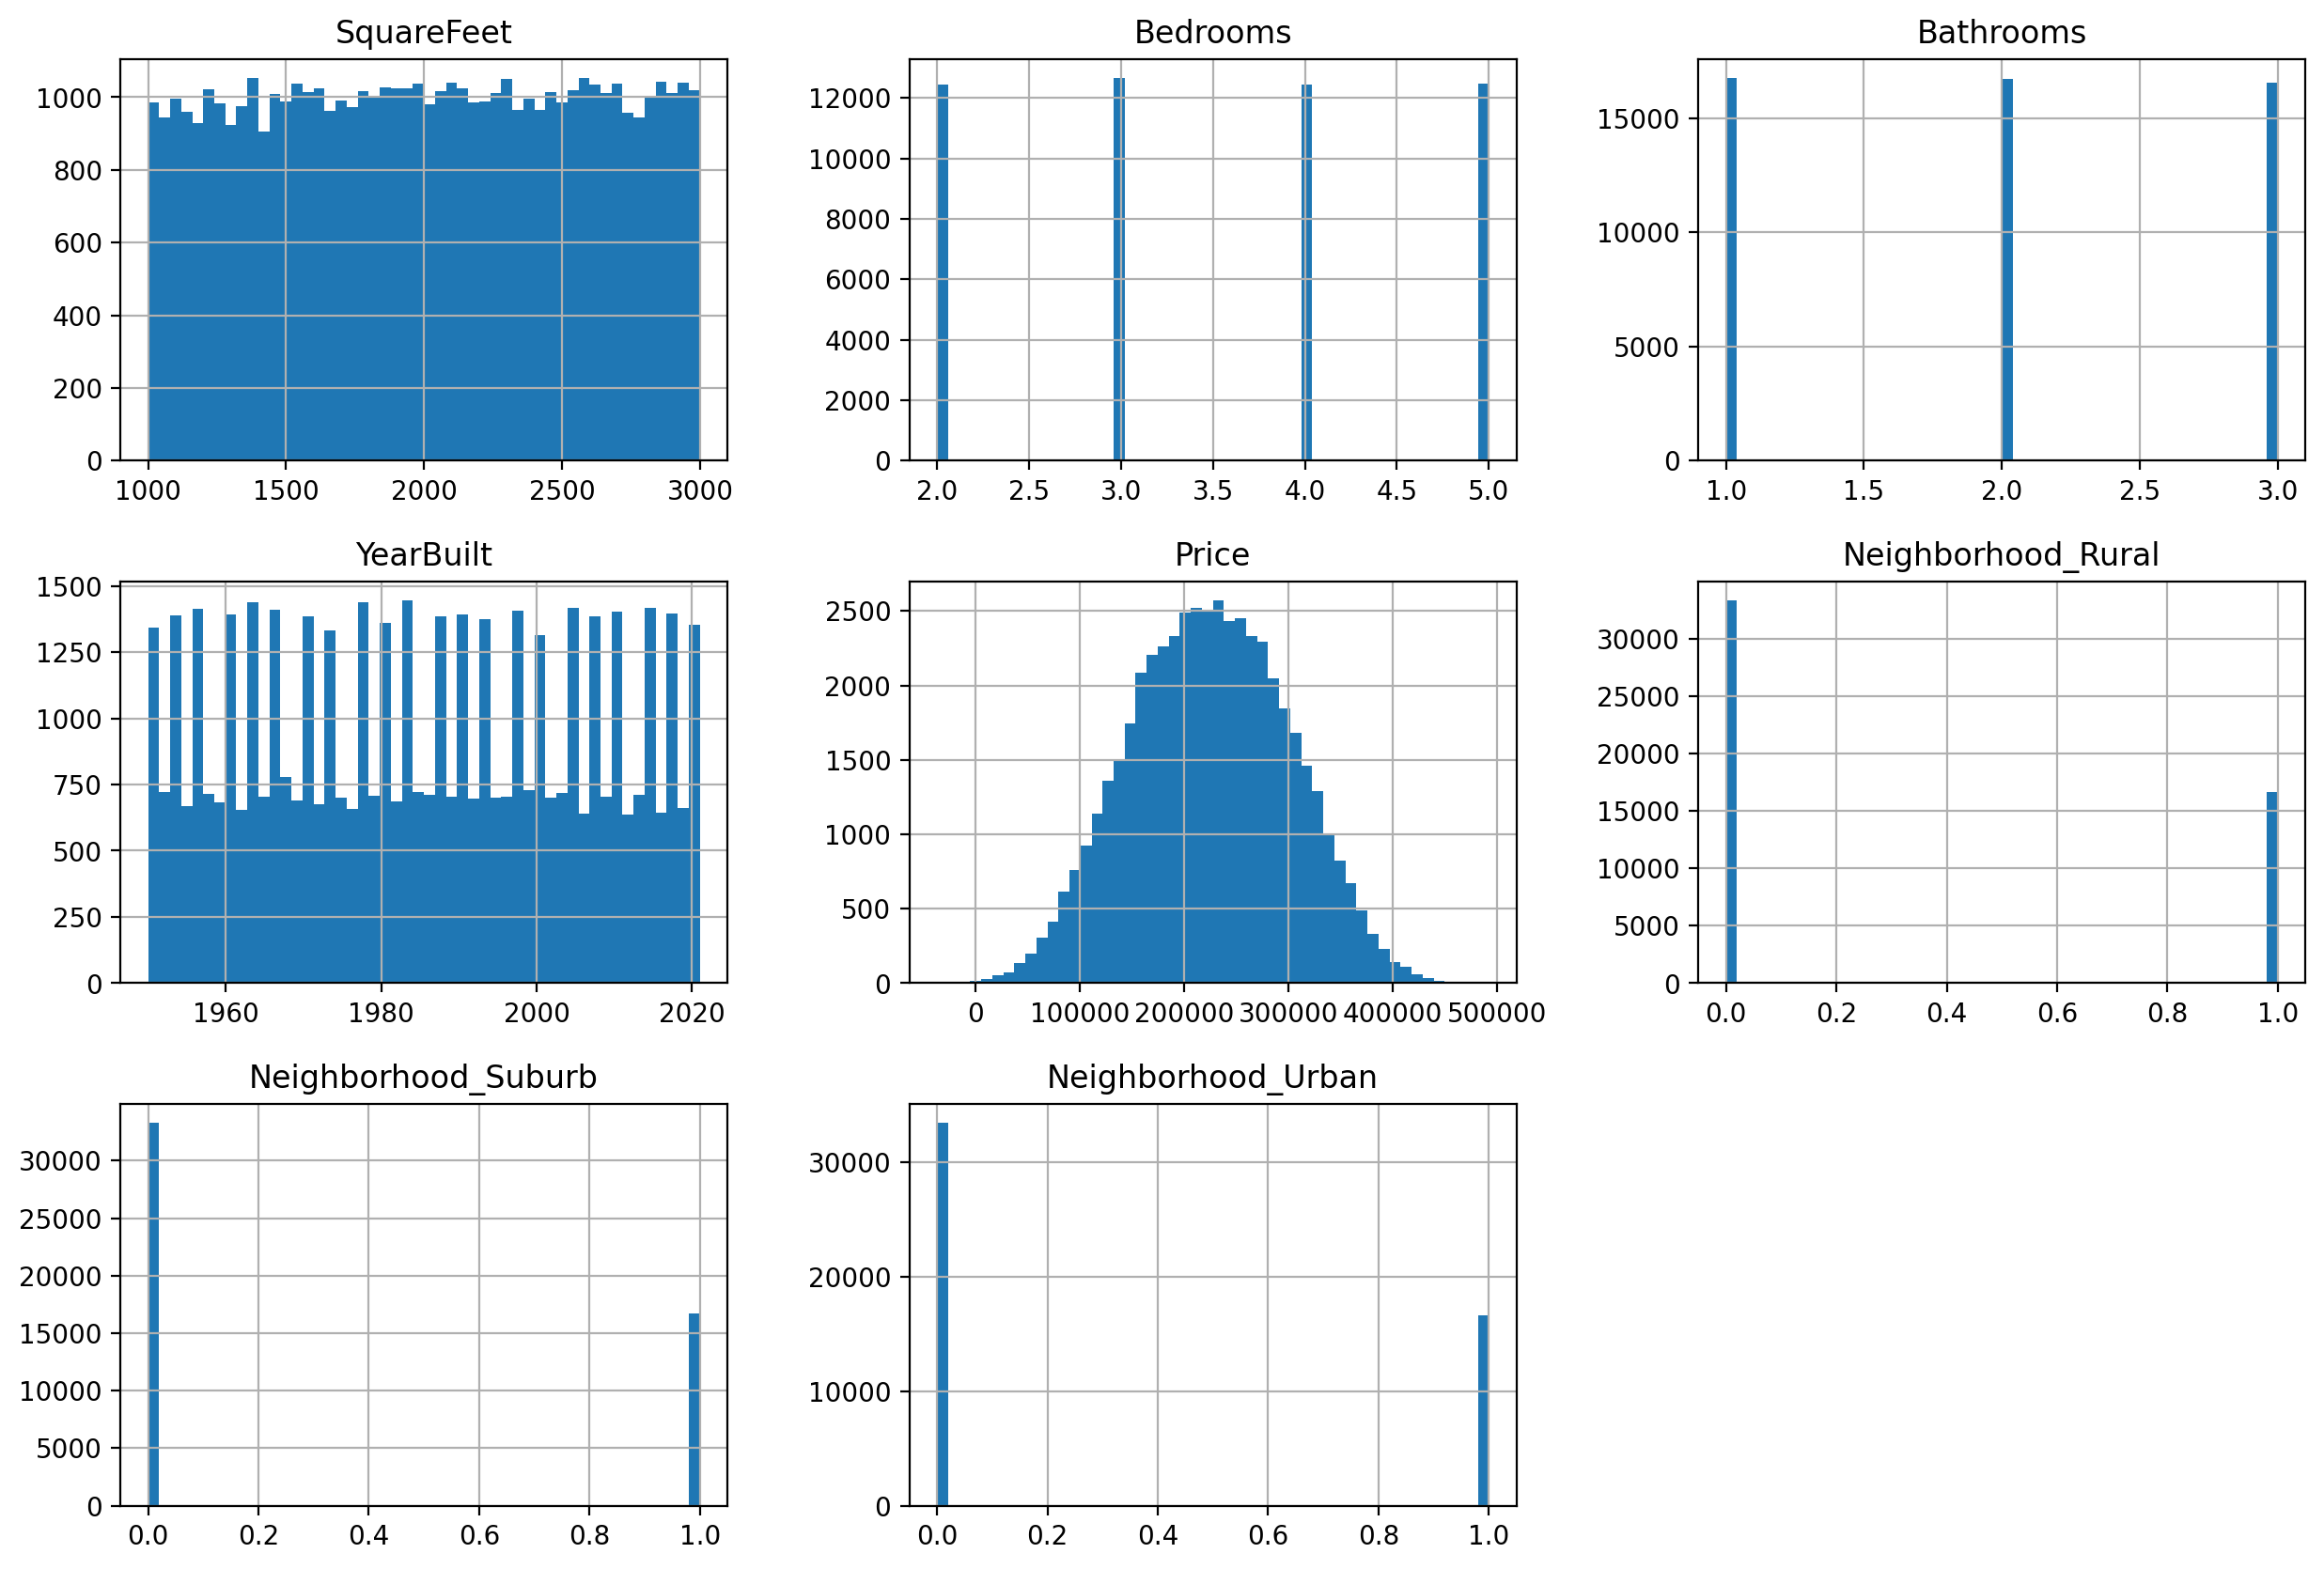

In [87]:
df.hist(figsize=(15,10), bins=50)

<Axes: xlabel='SquareFeet', ylabel='Price'>

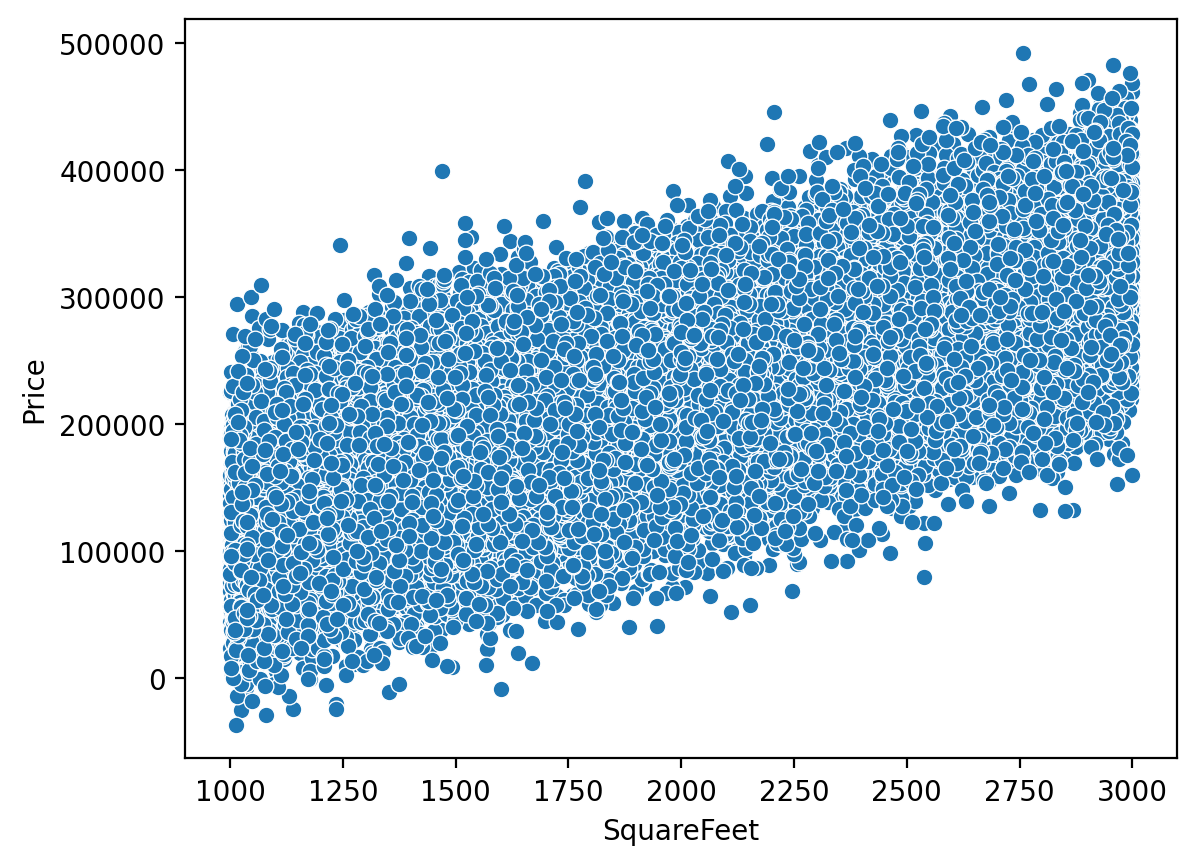

In [88]:
sns.scatterplot(x=df['SquareFeet'], y=df['Price'])

<Axes: xlabel='Neighborhood_Rural', ylabel='Price'>

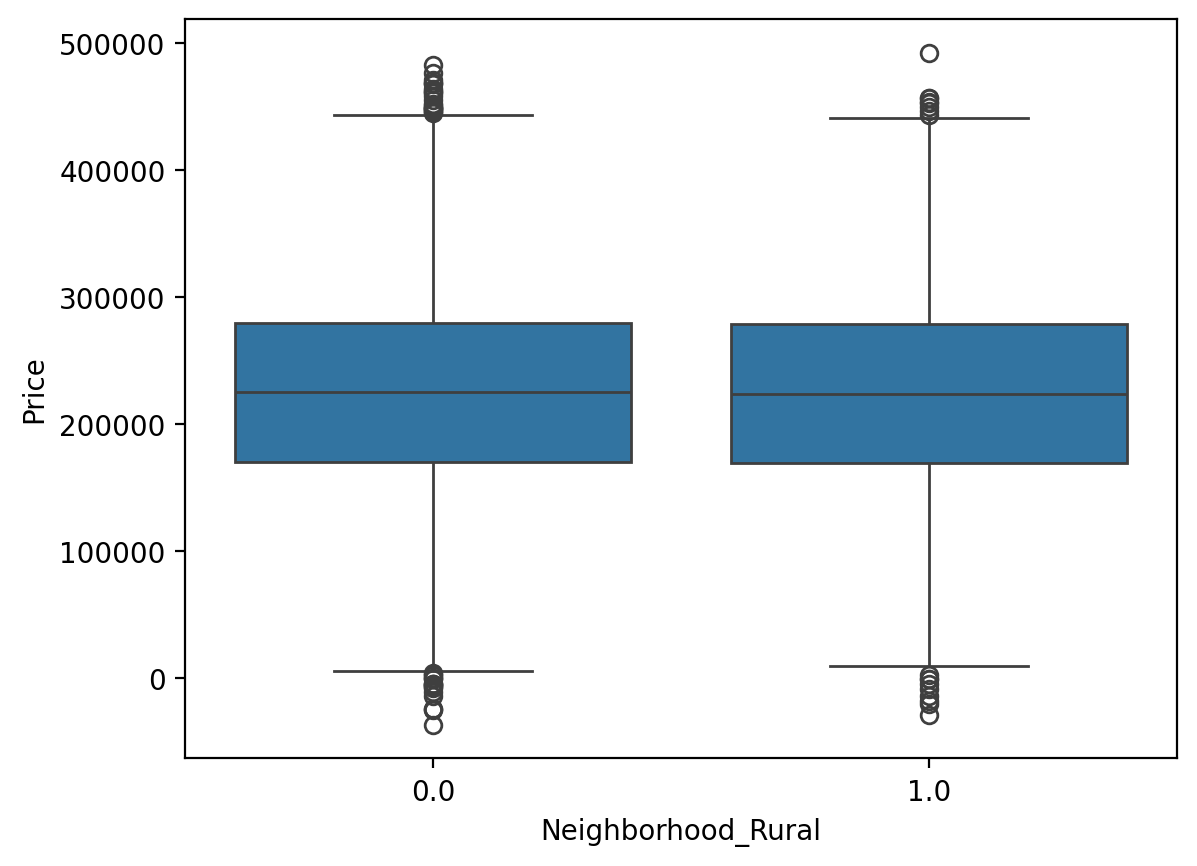

In [90]:
sns.boxplot(x=df['Neighborhood_Rural'], y=df['Price'])

<Axes: xlabel='Bedrooms', ylabel='Price'>

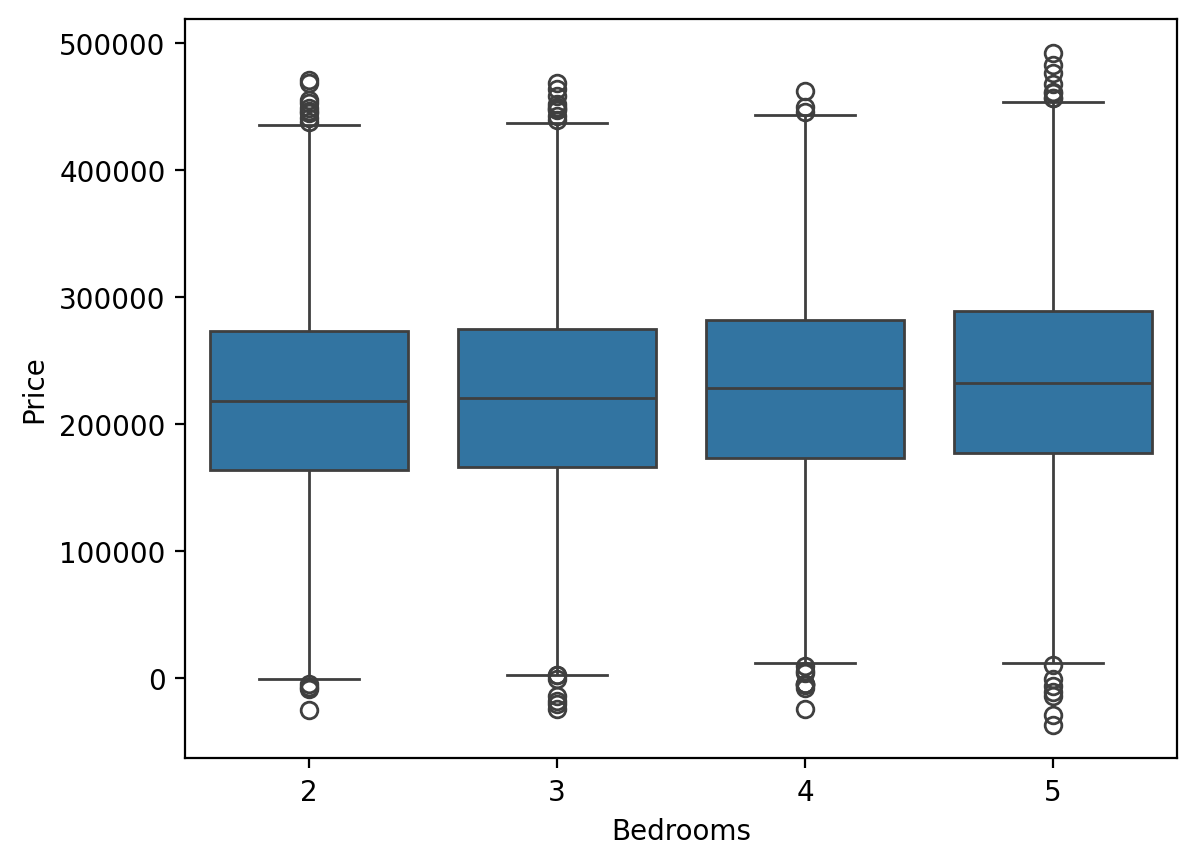

In [91]:
sns.boxplot(x=df['Bedrooms'], y=df['Price'])

In [92]:
zero_df = df[df['Price'] < 0]
print(zero_df)

       SquareFeet  Bedrooms  Bathrooms  YearBuilt         Price  \
1266         1024         2          2       2006 -24715.242482   
2310         1036         4          1       1983  -7550.504574   
3630         1235         3          2       2012 -19871.251146   
4162         1352         5          2       1977 -10608.359522   
5118         1140         4          1       2020 -23911.003119   
5951         1097         4          3       1981  -4537.418615   
6355         1016         5          2       1997 -13803.684059   
8720         1235         3          1       1952 -24183.000515   
9611         1131         3          3       1959 -13692.026068   
10597        1177         2          3       2010   -434.097124   
11991        1213         4          1       2020  -4910.415323   
17442        1600         2          3       1989  -8238.884499   
17706        1080         5          1       1955 -28774.998022   
20211        1049         3          1       2005 -18159.68567

In [107]:
df = df[df['Price'] >= 100000]
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The ML task is to predict house prices based on various features such as the size of the house(SquareFeed), number of bedrooms, number of bathrooms, the neighborhood(Neighborhood), and the year the house was built(YearBuilt).

The goal is to develop a predictive model that can estimate the price of a house based on these characteristics.

Dataset was processed in the following areas:

1. handling categorical feature Neighborhood using One-Hot encoding.
2. Cut off datapoints with price lower than 100000.
The dataset creator generated the housing prices using a randomizer and prices lower than 100000 would not make much sense.

In [135]:
xgb_model = XGBRegressor(colsample_bytree = 0.3,learning_rate=0.1, max_depth = 3, alpha =10, n_estimators = 100)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"Train MSE: {mse:.4f}")
print(f"Train R^2: {r2:.4f}")
print(f"Train MAE: {mae:.4f}")

Train MSE: 2237572252.6595
Train R^2: 0.5398
Train MAE: 37927.8634


The model chosen is XGBoost Regressor. The performance was evaluated using three metrics: Mean Squared Error(mse), R-Squared(r2) and Mean Absolute Error(mae).

the mse is quite large, reflecting the high value range of house prices in the dataset. Given the wide distribution of house prices, the large squared differences between predicted and actual values is reasonable, indicating the model's ability to make accurate prediction on comparable scale.

the r2 score indicates that about 54 percent of the differencens in house prices in the dataset can be explained by the features included. Consider that a r2 score value of 0.5 is generally considered reasonable, the model's ability to capture the relationship between input features and house prices is decnet.

the mae tells that the model's predictions are off by approximately 37928 from the actual prices. Consider the wide range of prices, this error is considered reasonable.

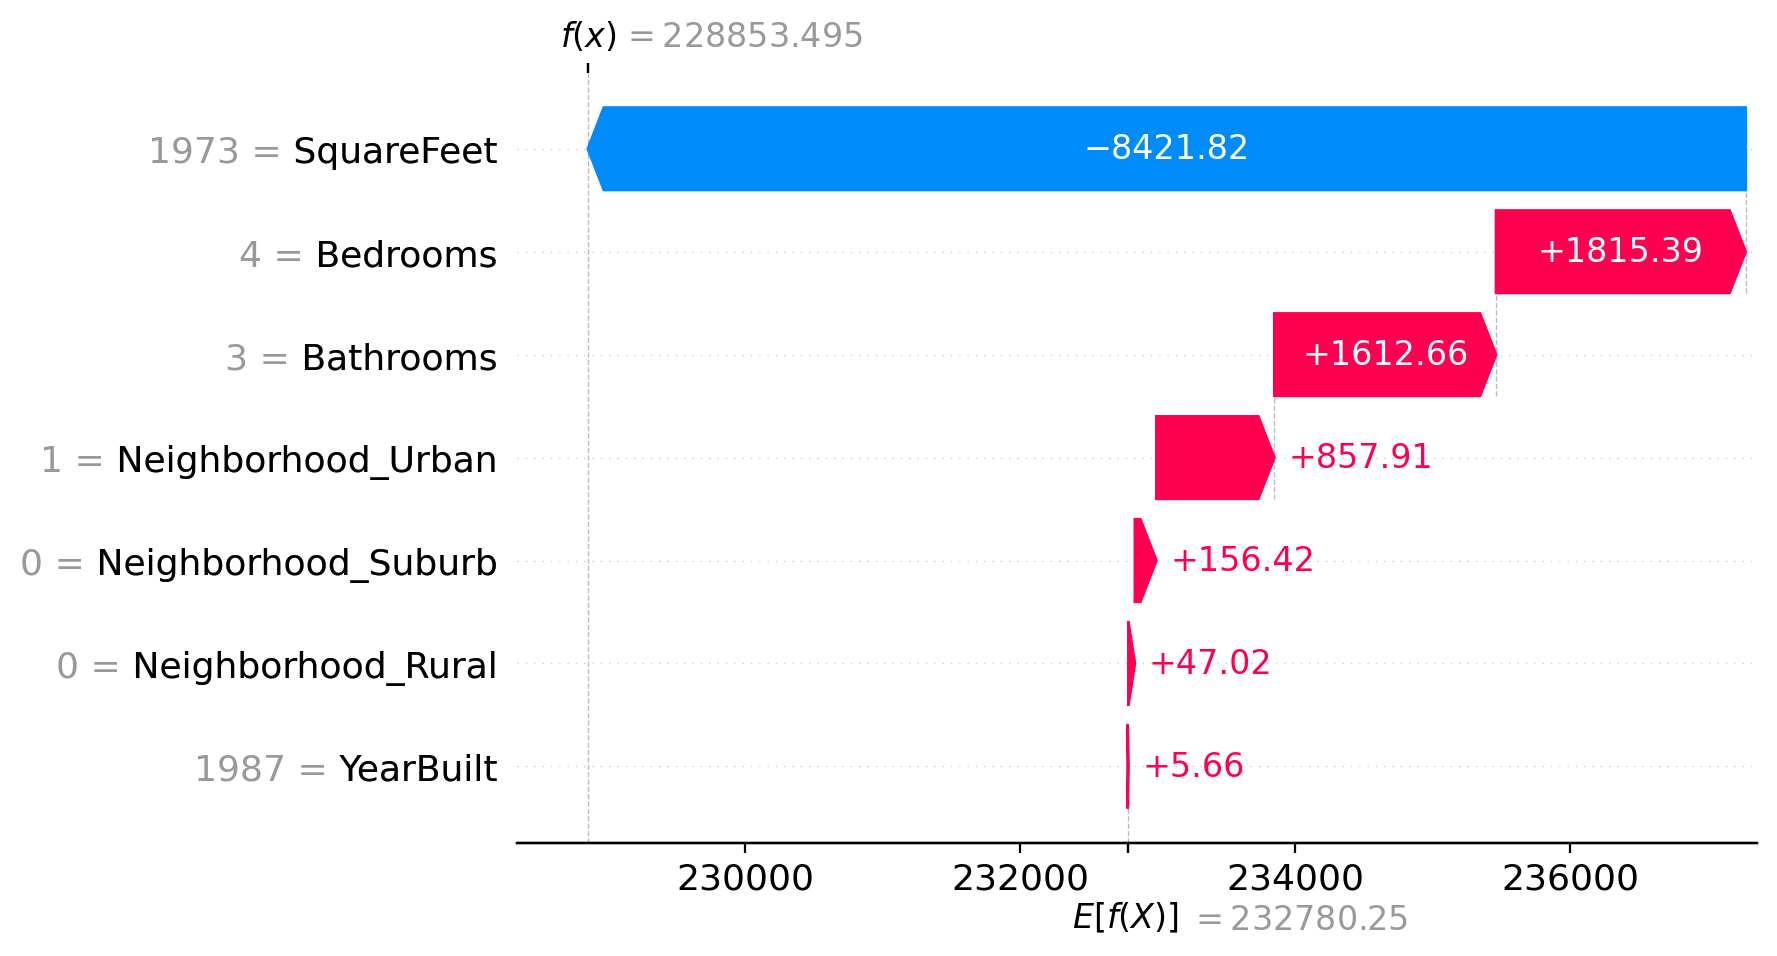

In [138]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test)

shap.waterfall_plot(shap_values[0])

In [141]:
shap.plots.initjs()
shap.plots.force(shap_values[0])

For this particular hosue (instance x0) with housing price predicted to be 228853 dollars, the square footage value of 1973 pushed the prediction down by roughly 8422 dollars compare to the average price prediction of 232780 dollars.  

This suggests that square footage of this house is significantly lower than expected for a house with the baseline price 232780.25

The bedrooms feature has a SHAP value of 1815.39, suggesting that havnig 4 bedrooms increased the preidcted prices by 1815.39 dollars. It also means that having 4 bedrooms is above average for houses in this dataset, contributing positively to the price.

Similarily, the bathrooms feature's SHAP value of 1612.66 suggests that having 3 bathrooms adds about 1612 dollars to the predicted price. Also, having 3 bathrooms is above average for houses in this dataset.

The neighborhood type variables' SHAP values suggest that urban neighborhood is considered to be the most attractive.

The year built 1987 has a very small SHAP value of +5.66, indicating that this built year is very close to average for hosues in the dataset.

The force plot intuitively visualzied how different features influenced the prediction. The blue arrow (SquareFeed) puuls to the left(lower values), while the red arrows(Bedrooms, Bathrooms, and Urban locations) puuls to the right(higher values). The length of each arrow represents the strength of that feature's influence (magnitude).

In [144]:
shap.plots.initjs()
shap.plots.force(shap_values[:50])

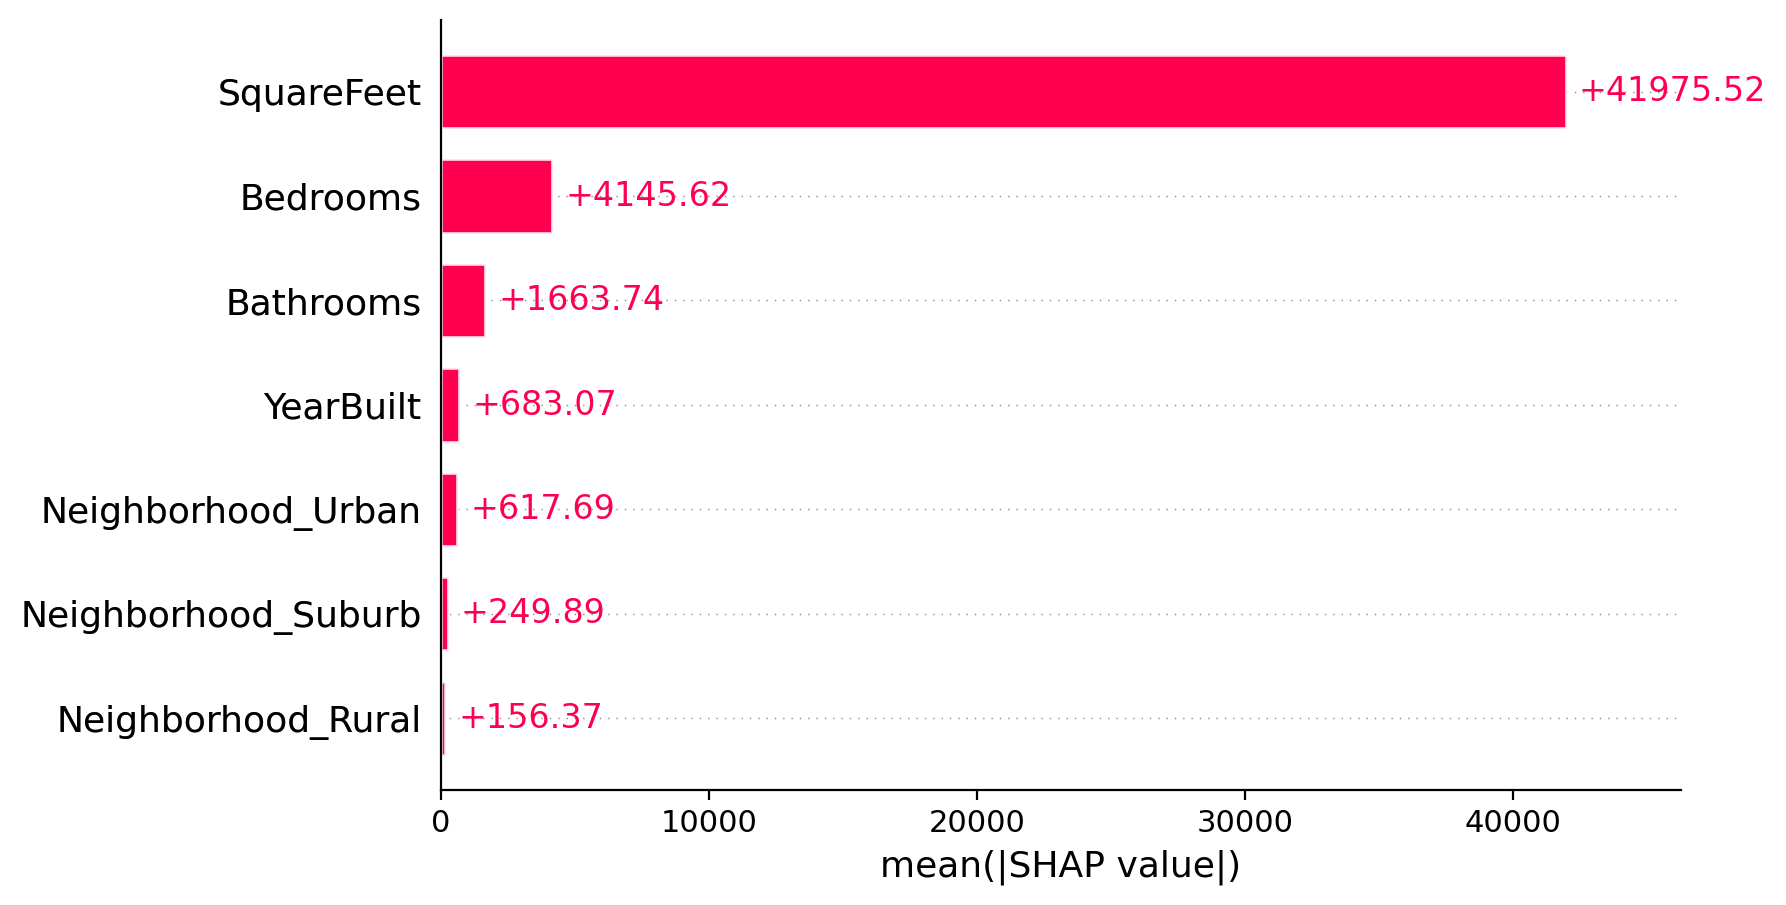

In [145]:
shap.plots.bar(shap_values)

The shap dependence plot shows the relationship between square footage and its impact on house price predictions.
One can observe from the plot that predicted prices for smaller homes (around 1200 to 1400 square feet) clustered around 152800 - 172800 dollors. As square footage incrases, predicred prices increase non-uniformlly.
Houses around 1800 to 2200 square feet are predicted to be in the middle range. It is also observed that significant price increase occures in larger homes(2400 to 2800 square feet).


the mean absolute SHAP value plot visualized the average magnitude of SHAP values for each faeture included in the model. Square footage is clearly the most influential feature with an average absolute SHAP value of 41975.52, meaning on average the square footage of a home can shift the predicted price up or down by approximately 42000 dollars compare to the baseline price.  The number of bedrooms is the second most important feature. Nevertheless, the significance of bedroom number is much lower compare to squared footage, even though more bedrooms typically means higher square footage. This can suggest that not only area size matters, but also layout.

## Task B - Image/Text data - 8 points

Your task is to build a **classification** model on some image/text data and explain predictions and observations using SHAP. It is up to you whether you want to use image or text data, but you need to select only one.

- **B1** - select the data and the model that you will use. Shortly describe what is the dataset, model type and model structure. Prepare the model and the data for the explanation (activate data loaders, load the checkpoint, etc.). **(4 points)**\
 *Recommendation:* You don't need to show model training, you can upload the checkpoint from one of the models from previous assignments or from the web
- **B2** - explain model predictions using SHAP. **(4 points)** \
 *Recommendation:* For image data show the image_plot and describe which pixels are important for prediction of different classes. For text_data show the text plot and describe which words are important for prediction of different classes.

*General recommendation:* The easiest and recommended way is to take the model from Assignment 2 (the VGG network), retrain it with `inplace=false` for ReLU (as shown in the tutorial) and use it for SHAP explanations. More advanced way is to use the transformer from Assignment 3. The hardest one is to find some custom model and dataset from the web. Grading does not depend on how advance option you take as the aim for you is to show your understanding rather than to build some complex models.

In [156]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# download the dataset
testset = torchvision.datasets.FashionMNIST(root=main_directory, train=False, download=True, transform=transform)

# define the labels of the images
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# specify the batch size for training and test
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)


The dataset chosen is the same one used in Assignment 2:

Fashion-MNIST, which consists of grayscale 28*28 pixel images with a label from 10 classes.

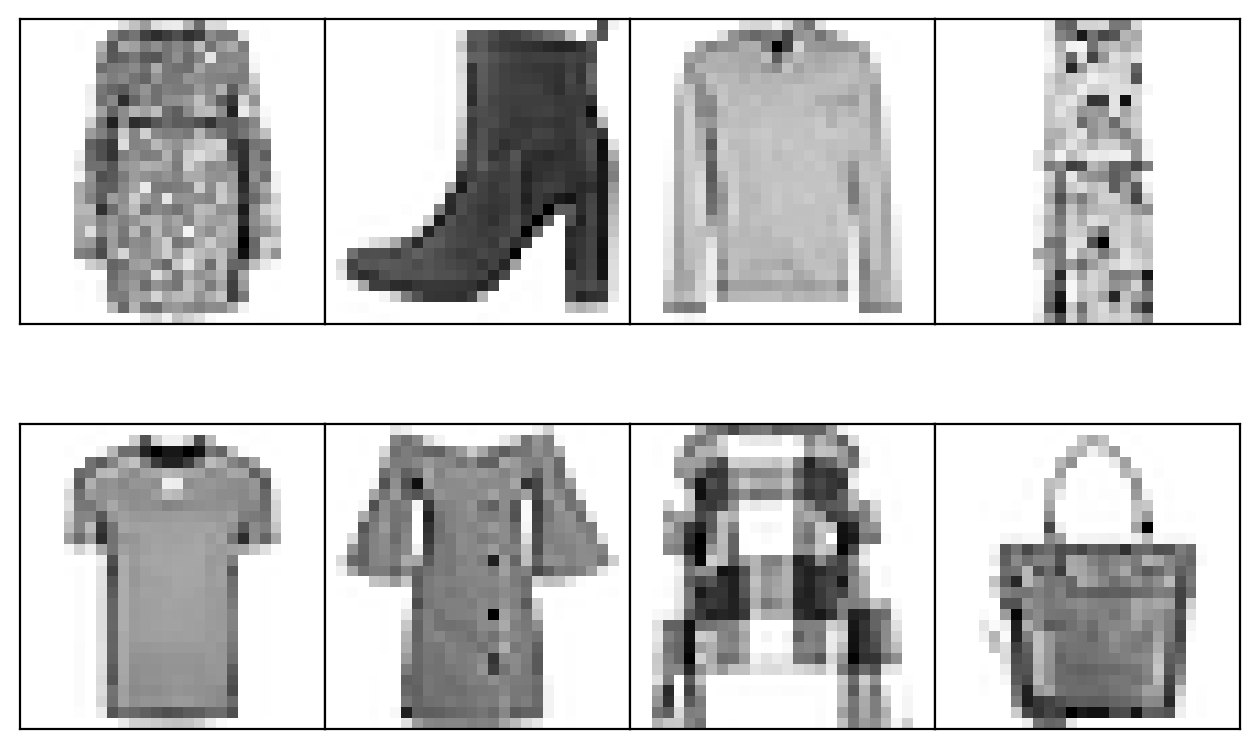

In [157]:
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

images, labels = next(iter(trainloader))
plot_images(images[:8], n_rows=2)

The model chosen is the model VGG19 used in Assignment 2, but re-trained with ReLu inplace set to False, which applies the ReLU activation function to a tensor and returns a new tensor with the results, without modifying the oridinal tensor. Trained model was saved in GoogleDrive main_directory and loaded directly.

The model VGG19 is a VGG stype convolutional Neural Network model designed to process grayscale images with dimensions of 28*28.

There are four convolutional layers arranged in two blocks. Each block contains two convolutional layers followed by max pooling. Starting with a single input channel, the network progressivelly expands the feature channels before contracting back to 20 channels, with each layer using 3*3 kernels. Each convolutional layer is followed by batch normalization and ReLU activation.

The fully connected layers take the processed image featuers and passes them through 3 dense layers to reduce dimensionality, which yields the final output of 10 classes.

In [160]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()


        self.convolutional_layer = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(1, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=False),

            # convolutional layer 2
            nn.Conv2d(20, 40, kernel_size=3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=False),

            # pooling layer 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 3
            nn.Conv2d(40, 60, kernel_size=3, padding=1),
            nn.BatchNorm2d(60),
            nn.ReLU(inplace=False),

            # convolutional layer 4
            nn.Conv2d(60, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=False),

            # pooling layer 2
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # fully connected layers
        self.linear_layer = nn.Sequential(
            nn.Linear(20*7*7, 100),
            nn.ReLU(inplace=False),
            nn.Linear(100, 50),
            nn.ReLU(inplace=False),
            nn.Linear(50, 10)
        )
    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
          verbose: True if you want to print the shapes of the intermediate variables.

        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        x = self.convolutional_layer(x)
        x = x.view(-1, 20*7*7)
        x = self.linear_layer(x)
        return x

In [168]:
model = VGGNet()

model_name = 'vgg_net.pth'
model.load_state_dict(torch.load(os.path.join(main_directory, model_name), map_location=torch.device('cpu')))

model.eval()

<ipython-input-168-1a2851f3af64>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(main_directory, model_name), map_location=tor

VGGNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(60, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=98

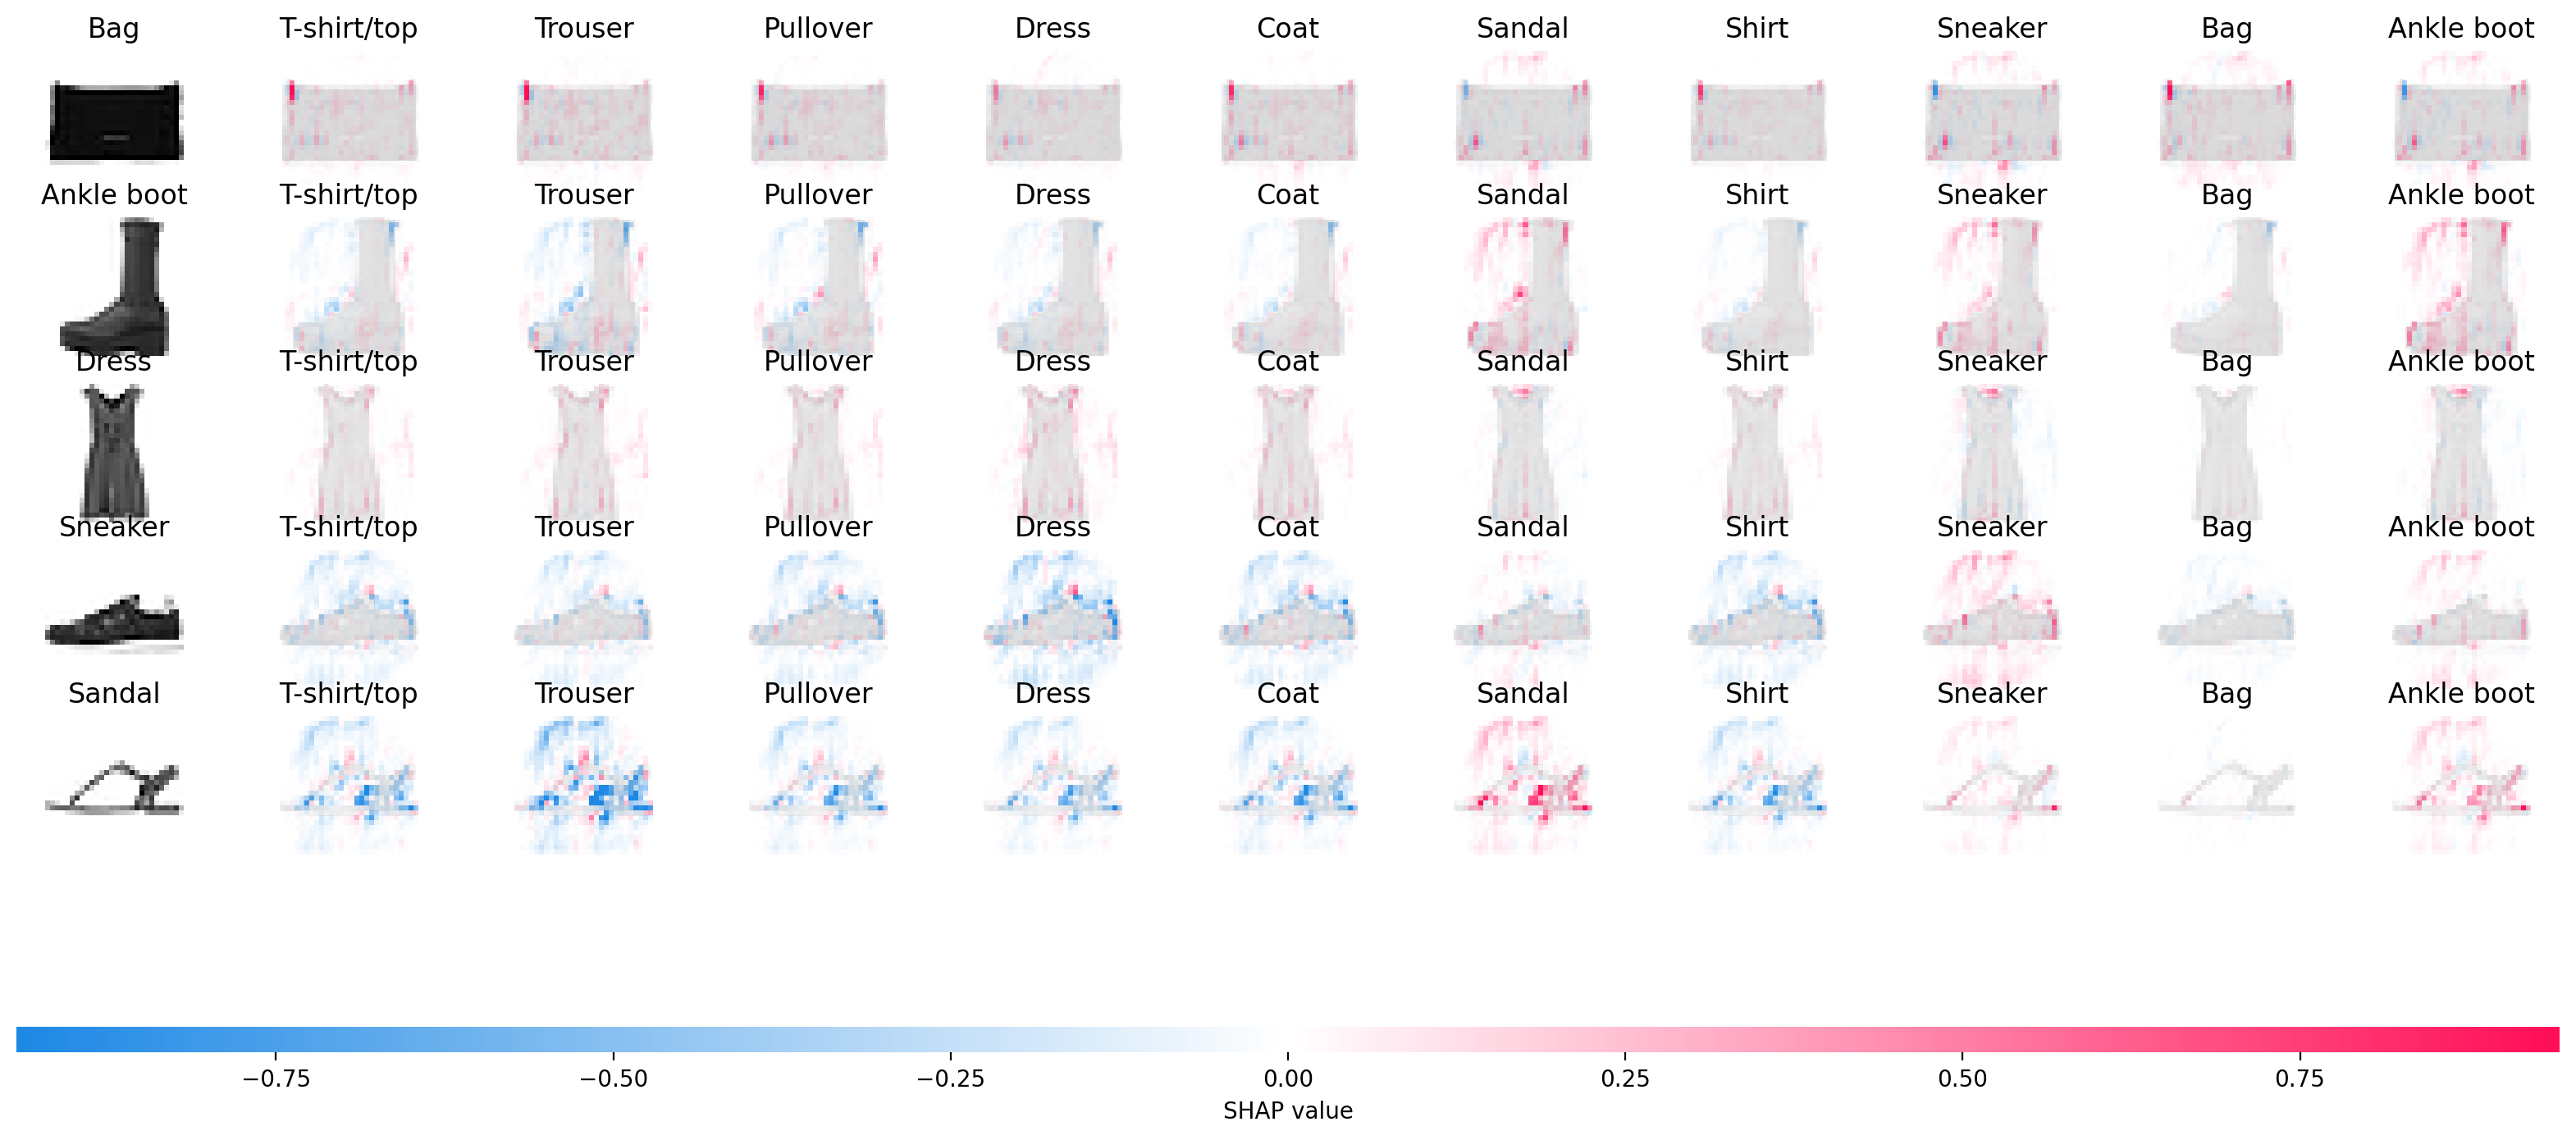

In [166]:
# create a loader with a batch of images
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
images, true_labels = next(iter(test_loader))

# train images will be used to calculate the approximate shapley values
background = images[np.random.choice(images.shape[0], 100, replace=False)]

# images to assess shapley values
# make sure that the sum of train and test images are less than the batch_size
test_images = images[120:125]

# initialize the DeepExplainer with the model instance and images for training being the parameters
explainer_img = shap.DeepExplainer(model, background)

# calculate approximate shapley values using our test dataset
shap_values_img = explainer_img.shap_values(test_images)

# reshape arrays for proper visualization
shap_numpy = list(np.transpose(shap_values_img, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

# create labels for vizualizations
classes_labels = np.array(classes)
for i in range(len(test_images)-1):
    classes_labels = np.vstack([np.array(classes), classes_labels])

# create true labels for vizualizations
tl = [classes[idx] for idx in true_labels[120:125].numpy()]

shap.image_plot(shap_numpy,-test_numpy, true_labels=tl, labels = classes_labels)

The SHAP value plot reveals how individual pixels contribute to image classification prediction. Blue indicates pixels that decrease the probability, while red shows pixels that increase it.

For Bags, the most discriminative pixels are concentrated around the structured outline, particularly the sharp corners at the top left and right. These geometric elements are crucial because they capture the rectangular shape that distinguishes bags from clothing items. The model has learned that these straight edges and corners are rarely present in other fashion categories.

For ankle boot, strong positive values appear across three footwear classes: Scandal, Sneaker, and Ankle boot, with the strongest activation for Ankle boots. The unique part of Ankle boot shape - the vertical shaft extending above the ankle and the distinct part above instep area contributed the most for differentiation.

Most important pixels for prediction on Dress cluster around the dress outline, and the fabric texture details, particularly the wrinkles and draping patterns.

For Sneaker, the most important pixels are around the heel, sole and shoelaces, which differentiate sneaker images apart from other footwear types.

For Sandle, the negative space between straps creates a distinctive pattern. Pixels around the sandle straps and particularly around the inner space are the most important.

The overall pattern revealls that the model prioritizes pixels that capture fundamental shape characteristics and distinctive design elements unique to each category.